### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='SBBSSBSB'
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12246
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1627.0| 42.8975|-106.4636|       TMAX|USW00024089|    11|[00 4F 00 C6 00 7...|1949.0|SBBSSBSB|
|   1627.0| 42.8975|-106.4636|       TMAX|USW00024089|     3|[80 54 E0 50 00 7...|1950.0|SBBSSBSB|
|   1627.0| 42.8975|-106.4636|       TMAX|USW00024089|     6|[80 D1 00 CF 20 5...|1951.0|SBBSSBSB|
|   1627.0| 42.8975|-106.4636|       TMAX|USW00024089|     2|[40 D6 30 D5 40 D...|1952.0|SBBSSBSB|
|   1627.0| 42.8975|-106.4636|       TMAX|USW00024089|     0|[00 00 00 00 30 5...|1953.0|SBBSSBSB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00198301')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USW00024089')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USW00024089'
64 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1627.0| 42.8975|-106.4636|       PRCP|USW00024089|     0|[00 00 00 48 90 5...|1949.0|SBBSSBSB|
|   1627.0| 42.8975|-106.4636|       PRCP|USW00024089|     0|[00 00 60 51 00 4...|1950.0|SBBSSBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(64, 365)

### Script for plotting yearly plots

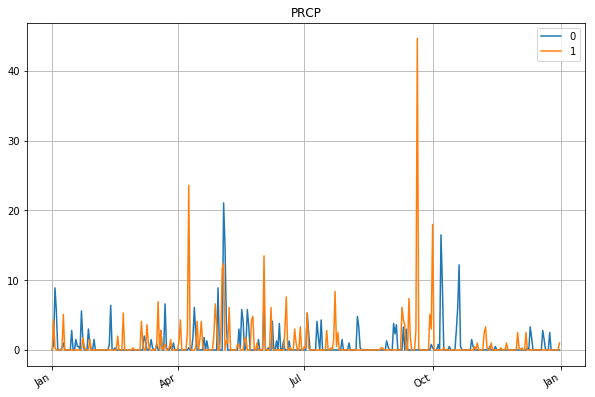

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func,tenths, ylab1, ylab2):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        axes[0].set_ylabel(ylab1)
        axes[1].set_ylabel(ylab2)
        func(m,fig,axis,tenths)
    # Save just the portion _inside_ the second axis's boundaries
    extent = axes[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    return extent
        
def plot_valid(m,fig,axis,tenths):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+ m)
    

/home/ucsd/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


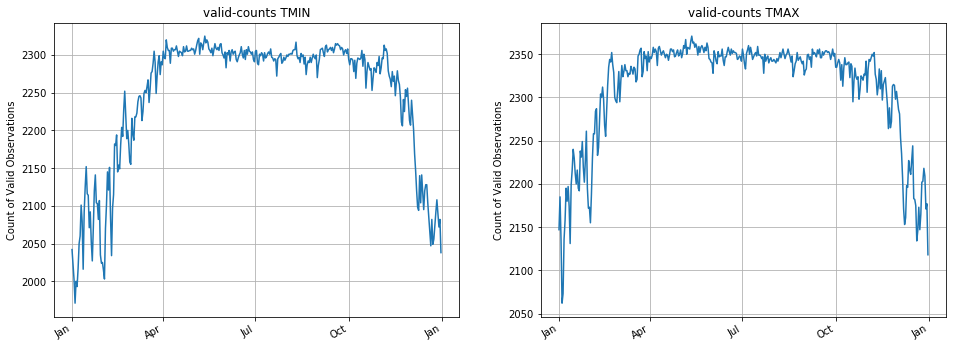

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid,0,'Count of Valid Observations','Count of Valid Observations');


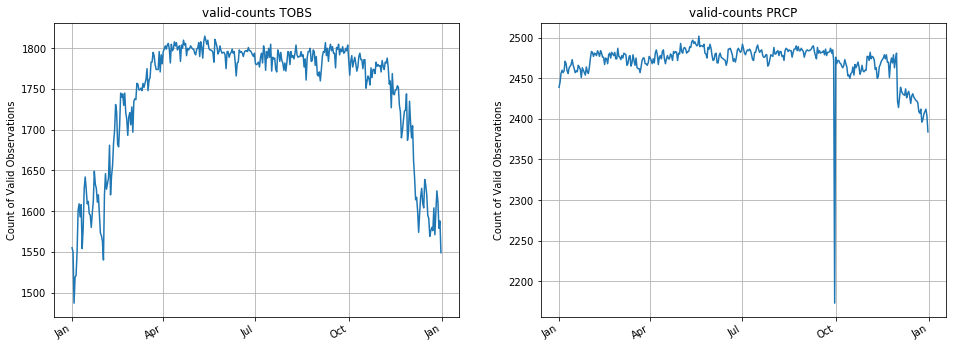

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid,0, 'Count of Valid Observations','Count of Valid Observations');

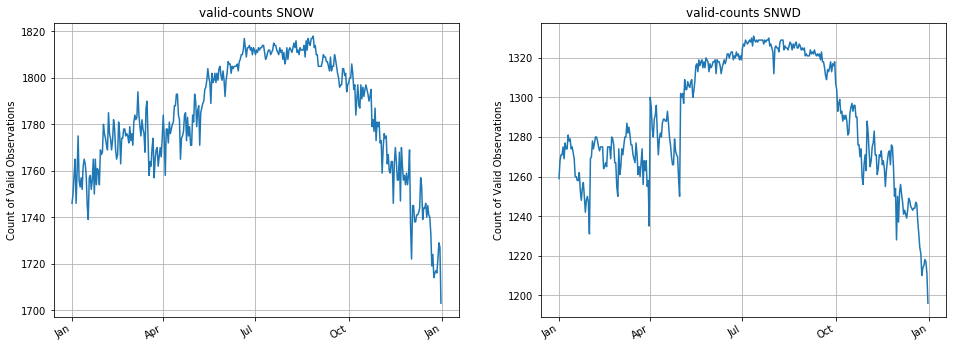

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid, 0,'Count of Valid Observations','Count of Valid Observations');

### Plots of mean and std of observations

In [8]:
def plot_mean_std(m,fig,axis,tenths):
    if tenths == 1:
        mean=(STAT[m]['Mean'])/10
        std=(np.sqrt(STAT[m]['Var']))/10
    else:
        mean=STAT[m]['Mean']
        std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)
    

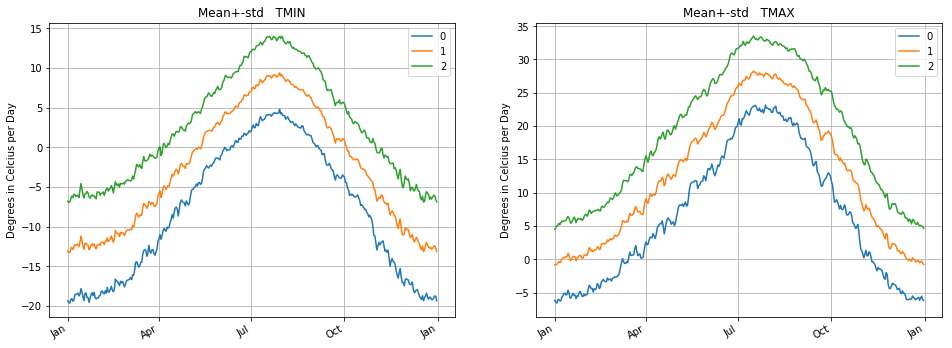

In [9]:
plot_pair(['TMIN','TMAX'],plot_mean_std,1,'Degrees in Celcius per Day','Degrees in Celcius per Day')
plt.savefig("HW5_figures/TMIN-TMAX.png",dpi=300)

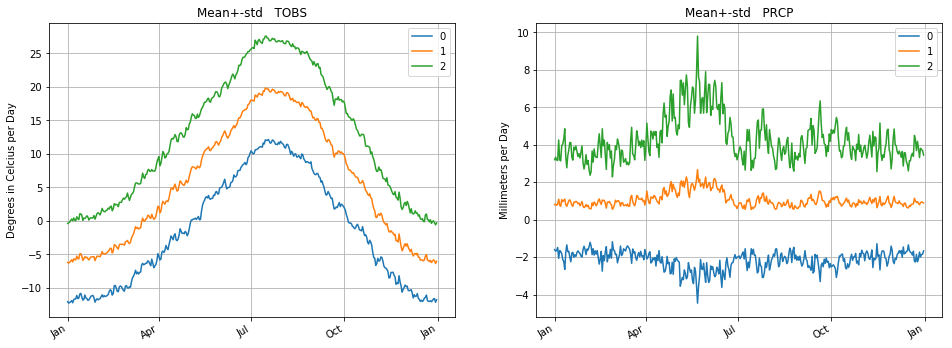

In [10]:
extent = plot_pair(['TOBS','PRCP'],plot_mean_std,1,'Degrees in Celcius per Day','Millimeters per Day')

# Save the full figure...
plt.savefig("HW5_figures/TOBS-PRCP.png",dpi=300)

# Save just the portion _inside_ the second axis's boundaries
#extent = axes[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('HW5_figures/PRCP.png', bbox_inches=extent)

# Pad the saved area by 20% in the x-direction and 30% in the y-direction
plt.savefig('HW5_figures/PRCP_expanded.png', bbox_inches=extent.expanded(1.3, 1.2))

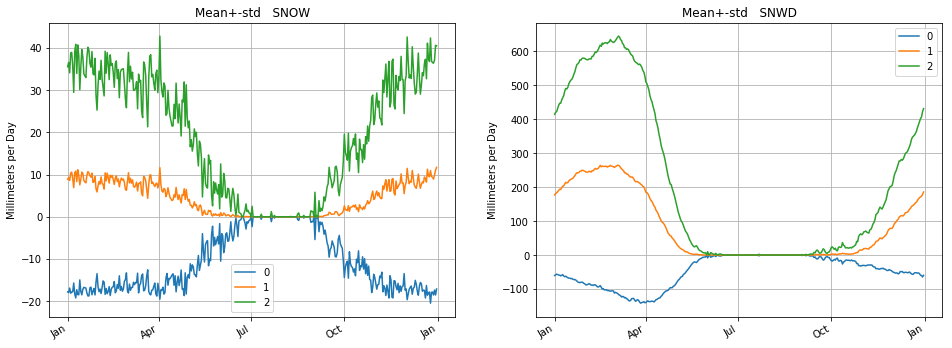

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std,0,'Millimeters per Day','Millimeters per Day');

### plotting top 3 eigenvectors

In [12]:
def plot_eigen(m,fig,axis,tenths):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

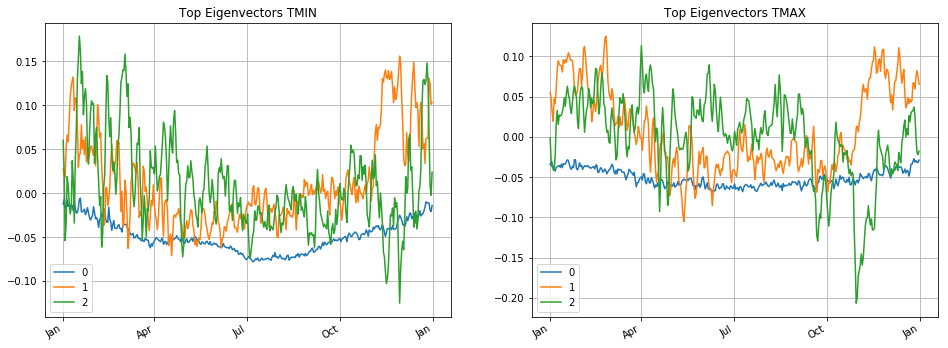

In [13]:
plot_pair(['TMIN','TMAX'],plot_eigen,1,'','');

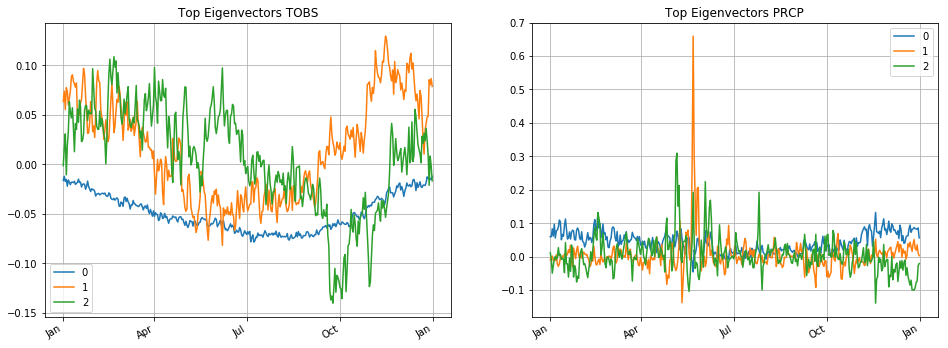

In [14]:
plot_pair(['TOBS','PRCP'],plot_eigen,1,'','');

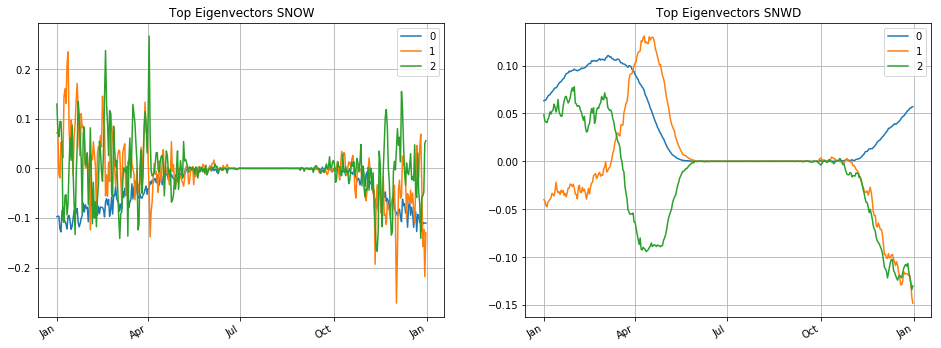

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_eigen,1,'','');

### Script for plotting percentage of variance explained

In [16]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

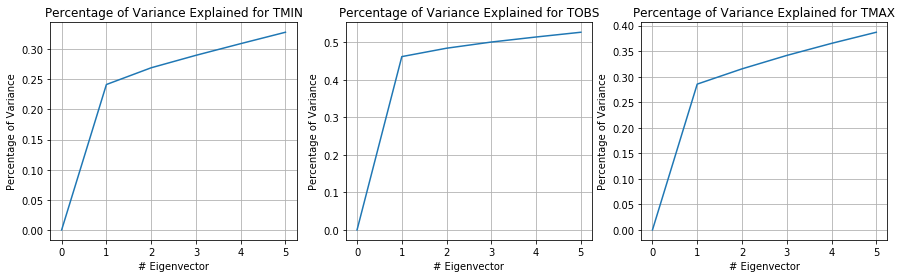

In [17]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
plt.savefig("HW5_figures/VarExplained1.png",dpi=300)

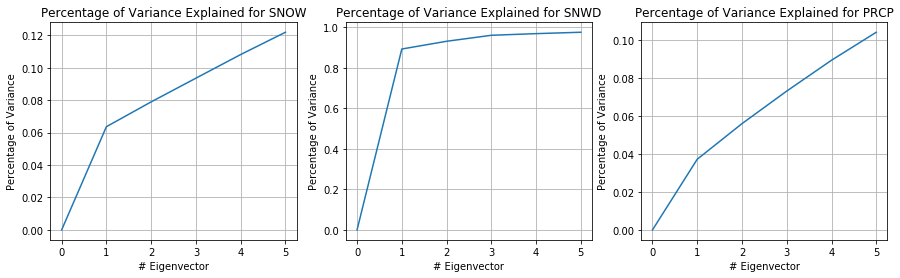

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
plt.savefig("HW5_figures/VarExplained2.png",dpi=300)

In [19]:
#sc.stop()